In [1]:
#Import pandas, matplotlib.pyplot, and seaborn 
import pandas as pd
import numpy as np
import math
import missingno as msno
import datetime as dt
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_profiling
from pandas_profiling.utils.cache import cache_file

import calendar
from scipy.signal import argrelextrema


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import statsmodels.api as sm

import lightgbm
from bayes_opt import BayesianOptimization

In [2]:
data = pd.read_excel('data2017_2020.xlsx')
print(data.shape)
data.head()

(412, 5)


,RATE,month_start,DWEL_UNIT,days_to_count_in_period,usage_to_count_in_period
0,COM,2016-04-01,1,19,1.4
1,COM,2016-05-01,1,12,0.5
2,COM,2016-11-01,3,56,5.7
3,COM,2016-12-01,4,62,6.7
4,COM,2017-01-01,5,69,8.4


**During data wrangling, I separated Pure Commercial from Commercial and Residential customers to correct**
**the number of dwelling and know the percentage of pure commercial customers in commercial group.**

**High proportion of commercial customers are pure commercial. Now for exploration and modling, I merge these subgroups**
**as commercial group.**

In [3]:
data.RATE = data.RATE.replace({'COM&RES':'COM'})

data = data.groupby(['RATE', 'month_start'])[['DWEL_UNIT','usage_to_count_in_period']].\
    sum().reset_index()
data.columns = ['RATE', 'month_start', 'DWEL_UNIT','usage']
print(data.shape)
data.head()

(270, 4)


,RATE,month_start,DWEL_UNIT,usage
0,COM,2016-04-01,2,6.1
1,COM,2016-05-01,1,0.5
2,COM,2016-11-01,3,5.7
3,COM,2016-12-01,4,6.7
4,COM,2017-01-01,5,8.4


In [4]:
#Filter water usage for Jul-2017 to Jul-2020
data = data[(data.month_start > '2017-7-01') & (data.month_start < '2020-07-01')]
data.shape

(210, 4)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210 entries, 11 to 267
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   RATE         210 non-null    object        
 1   month_start  210 non-null    datetime64[ns]
 2   DWEL_UNIT    210 non-null    int64         
 3   usage        210 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 8.2+ KB


# Prepare daily usage time series 

In [6]:
data['year']= data.month_start.dt.year
data['month'] = data.month_start.dt.month
data.head()

,RATE,month_start,DWEL_UNIT,usage,year,month
11,COM,2017-08-01,11933,517040.4,2017,8
12,COM,2017-09-01,11837,444599.4,2017,9
13,COM,2017-10-01,13028,483258.2,2017,10
14,COM,2017-11-01,11916,411534.7,2017,11
15,COM,2017-12-01,11998,404455.6,2017,12


### Normalize usage

In [7]:
import calendar
data['Days_in_month'] = data[['year','month']].apply(lambda x: calendar.monthrange(x[0],x[1])[1], axis= 1)
data['avg_daily_usage'] = data[['usage', 'Days_in_month']].apply(lambda x: x[0] / x[1] , axis= 1)
data['avg_daily_usage_per_dwl'] = data[['DWEL_UNIT','avg_daily_usage']].apply(lambda x: x[1]/x[0], axis=1)
data.head()

,RATE,month_start,DWEL_UNIT,usage,year,month,Days_in_month,avg_daily_usage,avg_daily_usage_per_dwl
11,COM,2017-08-01,11933,517040.4,2017,8,31,16678.722581,1.397697
12,COM,2017-09-01,11837,444599.4,2017,9,30,14819.980000,1.252005
13,COM,2017-10-01,13028,483258.2,2017,10,31,15588.974194,1.196575
14,COM,2017-11-01,11916,411534.7,2017,11,30,13717.823333,1.151210
15,COM,2017-12-01,11998,404455.6,2017,12,31,13046.954839,1.087427


In [8]:
#Groupby month to sum up the avg daily usage of all 6 customers groups
ts_usage = data.groupby('month_start')['avg_daily_usage_per_dwl'].sum()
print(ts_usage.shape)
ts_usage.head()

(35,)


month_start
2017-08-01    4.449854
2017-09-01    3.919119
2017-10-01    3.766953
2017-11-01    3.344390
2017-12-01    3.117547
Name: avg_daily_usage_per_dwl, dtype: float64

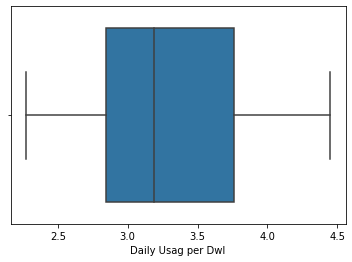

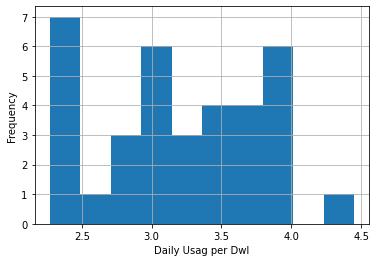

In [9]:
sns.boxplot(ts_usage.values)
plt.xlabel('Daily Usag per Dwl')
plt.show()
ts_usage.hist()
plt.xlabel('Daily Usag per Dwl')
plt.ylabel('Frequency')
plt.show()

# 1. Analysis and Transforms

## 1.1 Decompose usage time series 

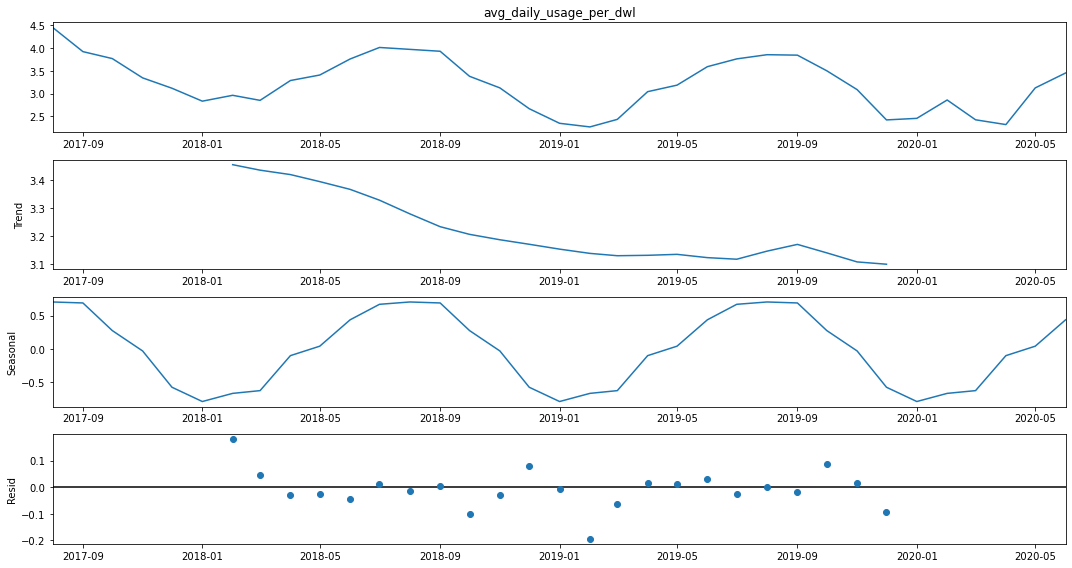

In [10]:
#Docompose time series of original usage
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

decomposition = seasonal_decompose(ts_usage, model= 'additive')

rcParams['figure.figsize'] = 15, 8
decomposition.plot()

pass

### Check Trend
Fitting and predicting Linear Regressor to know if time series has a trend.

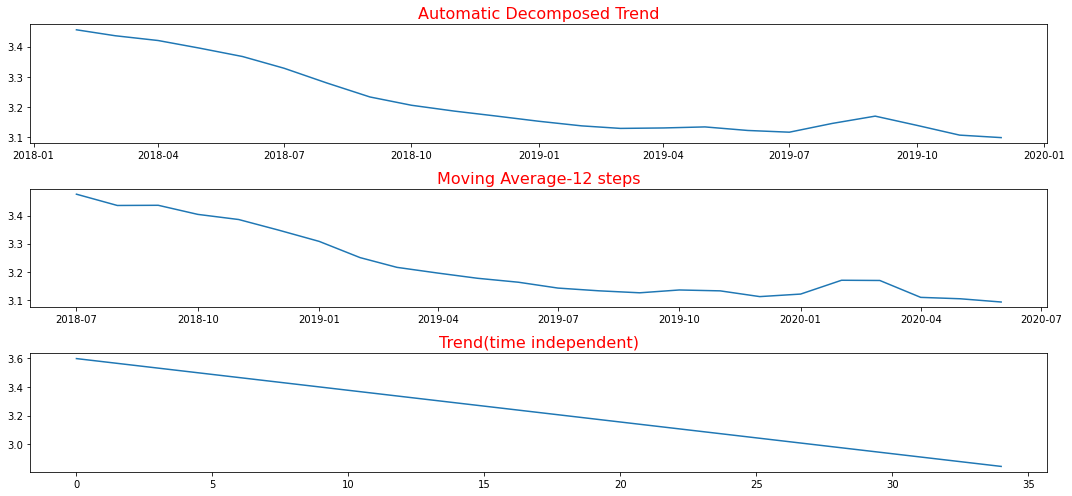

In [11]:
fig = plt.figure(figsize=(15, 7))
ax1 = plt.subplot2grid((3,1), (0,0))
ax2 = plt.subplot2grid((3,1), (1,0))
ax3 = plt.subplot2grid((3,1), (2,0))

#Plot the trend
ax1.plot(decomposition.trend)
ax1.set_title('Automatic Decomposed Trend',fontsize= 16, c='red')

#Plot moving average
rolling_mean = ts_usage.rolling(window= 12).mean()
ax2.plot(rolling_mean)
ax2.set_title('Moving Average-12 steps',fontsize= 16, c='red')


#Fit a linear regression to find a trend independent from time 
from sklearn.linear_model import LinearRegression
X = list(range(len(ts_usage)))
X = np.reshape(X, (len(X),1))

y = ts_usage.values
lr= LinearRegression()
lr.fit(X,y)
trend = lr.predict(X)
ax3.plot(trend)
ax3.set_title('Trend(time independent)',fontsize= 16, c='red')


plt.tight_layout()
plt.show()

**When I fitted linear regression on usage values (independent from time), the result of prediction is relatively close to the automatic decomposed trend. Time series usage seems to have a trend.**

### Check Seasonality

**In each year, usage has raised continuously from February to September, then from October to January of next year the usage has decreased. This distinct pattern repeated each year.**

Fitting a polynomial curve to find seasonality of time series.

C:\Users\bahra\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


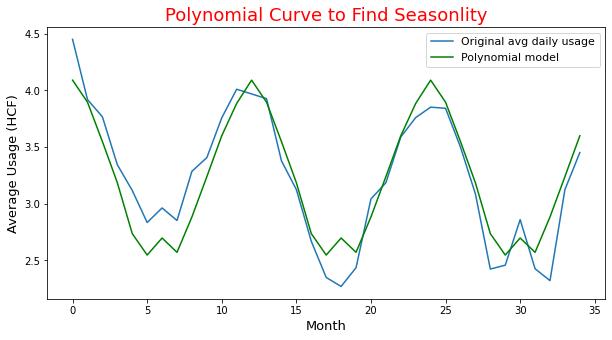

In [12]:
#each value on curve has value of x between 0 and 11.
X = [i%12 for i in range(len(ts_usage))]  
y = ts_usage.values
 
#fit a polynomial curve with degree of 100 on X and y   
degree = 100
coef = np.polyfit(X, y, degree)

#for each x in X, let's find its value on polynomial curve
curve = []
for i in range(len(X)):
    y_curve = coef[-1]    #add intercept value
    for d in range(degree):
        y_curve  += (X[i] **(degree-d)) * coef[d]
    curve.append(y_curve)    
    

#Plot the curve and original avg usage
plt.figure(figsize= (10,5))
plt.plot(ts_usage.values, label= 'Original avg daily usage')
plt.plot(curve, c= 'green', label= 'Polynomial model')


plt.legend(fontsize=11)
plt.xlabel('Month',fontsize=13)
plt.ylabel('Average Usage (HCF)',fontsize=13)
plt.title('Polynomial Curve to Find Seasonlity', color= 'red',fontsize=18)
plt.show()


**There is a yearly seasonality.**

### Check Noise

Check the histogram distribution of usage values to see if values have a Guassian distibution (N(0, sigma2))

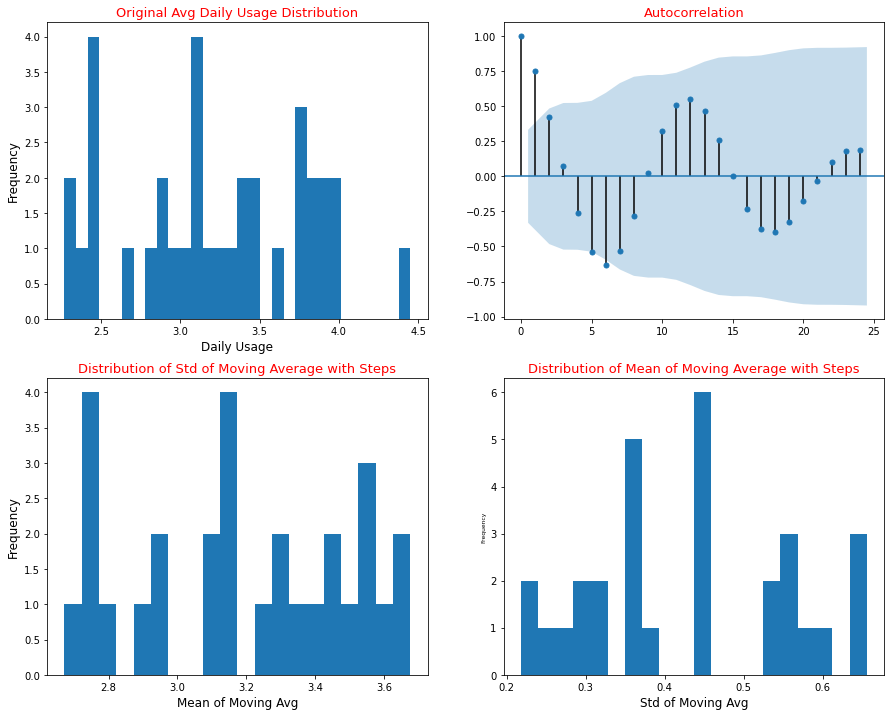

In [13]:
plt.figure(figsize=(15,12))
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (0,1))
ax3 = plt.subplot2grid((2,2), (1,0))
ax4 = plt.subplot2grid((2,2), (1,1))

#Plot distribution of daily usage values
ax1.hist(ts_usage, bins= 30)
ax1.set_title('Original Avg Daily Usage Distribution', c='red', fontsize=13)
ax1.set_ylabel('Frequency',fontsize=12)
ax1.set_xlabel('Daily Usage',fontsize=12)

#Plot autocorrelation
plot_acf(ts_usage, lags=24, ax=ax2)
ax2.set_title('Autocorrelation', c='red', fontsize=13)


#plot distribution of std for Moving Average with 12 steps
ax3.hist(ts_usage.rolling(window= 7).mean().dropna(), bins=20)
ax3.set_title('Distribution of Std of Moving Average with Steps', c='red', fontsize=13)
ax3.set_ylabel('Frequency',fontsize=12)
ax3.set_xlabel('Mean of Moving Avg',fontsize=12)

#plot distribution of std for Moving Average with 12 steps
ax4.hist(ts_usage.rolling(window= 6).std().dropna(), bins=20)
ax4.set_title('Distribution of Mean of Moving Average with Steps', c='red', fontsize=13)
ax4.set_ylabel('Frequency',fontsize= 6)
ax4.set_xlabel('Std of Moving Avg',fontsize=12)


plt.show()

#### 1) Daily usage doesn't have a Gaussian distribution
#### 2) Daily usage values are not independent, they are correlated with many values in the latter months




## 1.2. Stationary 

### Check stationary of time series using Augmented Dicky-Fuller test (ADF)

#### Is the time series of daily usage stationary or random walk?

**Null hypothesis:** the time series follows a random walk (There is a unit root)


**Alternative hypothesis:** The time series is stationary 

In [14]:
#Import the adfuller module from statsmodels
from statsmodels.tsa.stattools import adfuller


#Perform Dicky-Fuller test    
def adf_test(timeseries):  
    print('\nResults of Dickey-Fuller Test:')
        
    # Set autolag as AIC, so the number of lags is chosen to minimize the corresponding information criterion
    df_test = adfuller(timeseries, autolag= 'BIC') 


    df_output = pd.Series(df_test[0:4] , index= ['test statistic', 'p-value', '# Lags Used','# Observation Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value {}'.format(key)] = value
    print(df_output)   

In [15]:
#Define a function to test stationary of a time series
def test_stationary(timeseries):
    
    #plot rolling statistics
    plt.figure(figsize=(15,12))
    ax1= plt.subplot2grid((3,2),(0,0), colspan=2)
    ax2= plt.subplot2grid((3,2),(1,0))
    ax3= plt.subplot2grid((3,2),(1,1))
    ax4= plt.subplot2grid((3,2),(2,0), colspan=2)
    
    #plot original daily usage
    ax1.plot(timeseries, label= 'Original', color= 'green')
    ax1.grid(which='both')
    ax1.set_title('Original Time Series of Daily usage', color='red', fontsize=15)
    ax1.set_ylabel('Avg Daily Usage(HCF)', fontsize=14)
    
    #plot autocorrelation and partial autocorrelation
    plot_acf(timeseries, lags=20, ax= ax2)
    ax2.set_title('Autocorrelatio', color='red', fontsize=15)
    ax2.set_xlabel('Lag', fontsize=14)
    ax2.set_ylabel('ACF', fontsize=14)
    
    plot_pacf(timeseries, lags=20, ax= ax3)
    ax3.set_title('Partial Autocorrelation', color='red', fontsize=15)
    ax3.set_xlabel('Lag', fontsize=14)
    ax3.set_ylabel('PACF', fontsize=14)
    
    #Calculate mean and std of Moving avg 
    rol_mean = timeseries.rolling(window= 4).mean().dropna()
    rol_std = timeseries.rolling(window= 4).std().dropna()
    
    #plot mean of rolling or moving avg
    ax4.plot(rol_mean, label= 'Rolling Mean', color= 'red')
    
    #plot std of rolling or moving avg
    plt.plot(rol_std, label= 'Rollingstd')
    
    #plot original daily usage
    plt.plot(timeseries, label= 'Original', color= 'green')
    
    
    plt.ylabel('Daily Usage(HCF)', fontsize= 14)
    title = 'Rolling Mean and Stadard Deviation'
    plt.title(title, fontsize=16, color= 'red')
    ax4.grid(which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()    

C:\Users\bahra\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


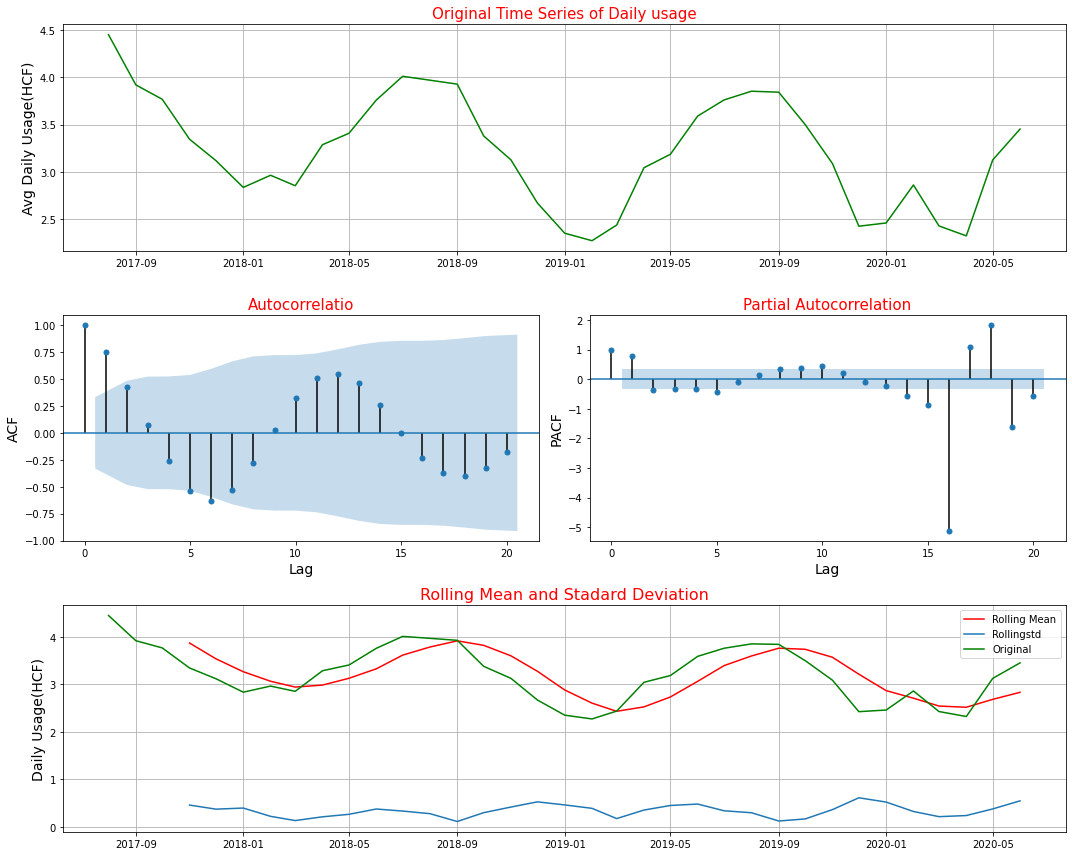

Original values

Results of Dickey-Fuller Test:
test statistic        -1.592271
p-value                0.487475
# Lags Used            8.000000
# Observation Used    26.000000
Critical Value 1%     -3.711212
Critical Value 5%     -2.981247
Critical Value 10%    -2.630095
dtype: float64


In [16]:
#Test stationarity for the 0 order of difference of usage 
test_stationary(ts_usage)

print('Original values')
adf_test(ts_usage)

###  test statistic > Critical value at all signifcant levels , so the null hypothesis cannot be rejected. Time series of water usage isnot stationary.

## 1.3 Stationarize data

Transform differencing to remove seasonality and trend.

In [17]:
#Groupby date to sum up the avg usage of all 6 groups
ts_usage = data.groupby('month_start')['avg_daily_usage_per_dwl'].sum()
print(ts_usage.shape)
ts_usage.head()

(35,)


month_start
2017-08-01    4.449854
2017-09-01    3.919119
2017-10-01    3.766953
2017-11-01    3.344390
2017-12-01    3.117547
Name: avg_daily_usage_per_dwl, dtype: float64

In [18]:
order=3
if order==1:
    id= lag
else:
    id= order

In [19]:
#Calculate the differenced time series values at the specified lag and order
#order or number of times to perform the differencing operation.
def difference(ts_value, lag=1, order=1):
    for u in range(order):
        diff = []
        for i in range(lag, len(ts_value)):
             diff.append(ts_value[i] - ts_value[i - lag])
        ts_value= diff
    return diff

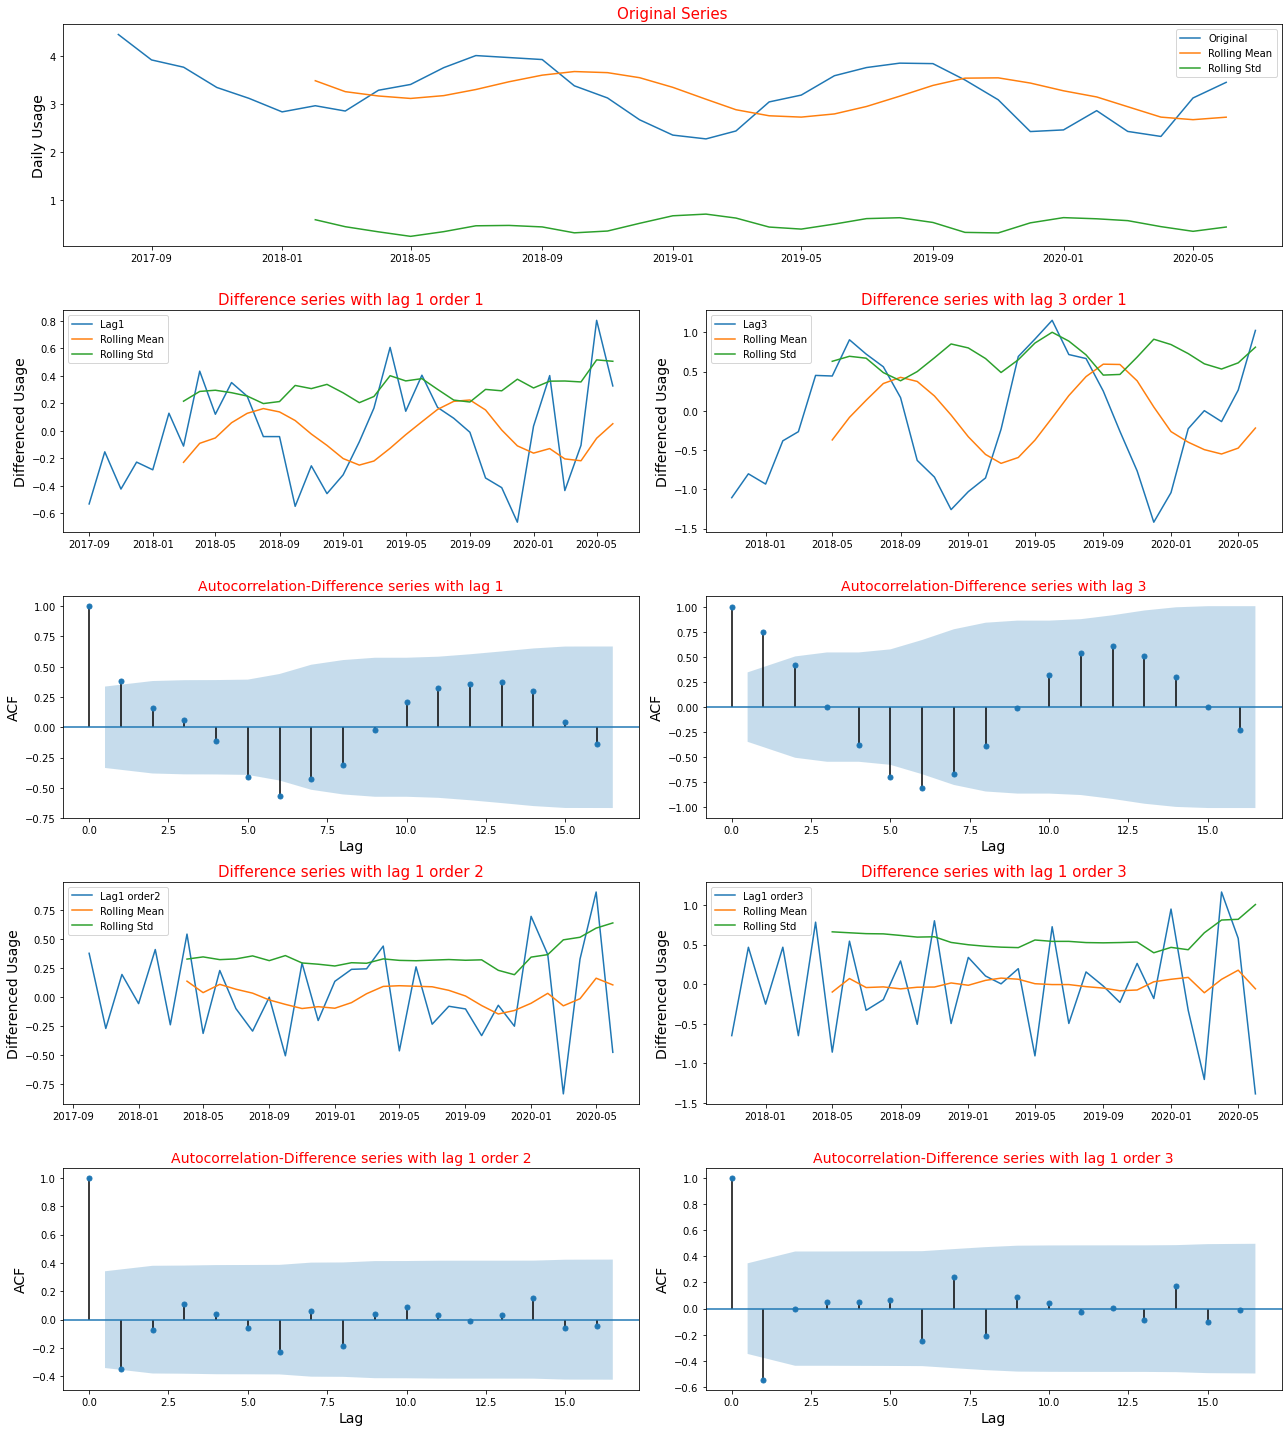

In [20]:
#Caluculate one lag of difference
id= 1
lag1series = pd.Series(difference(ts_usage.values, lag=1, order=1), index= ts_usage.index[id:])
#Calculate three lag of difference
id= 3
lag3series = pd.Series(difference(ts_usage.values, lag=3 , order= 1), index= ts_usage.index[id:])
#Calculate one lage of difference 2 times
id= 2
lag1order2series = pd.Series(difference(ts_usage.values, lag= 1 ,order= 2), index= ts_usage.index[id:])
#Calculate one lage of difference 2 times
id= 3
lag1order3series = pd.Series(difference(ts_usage.values, lag= 1 ,order= 3), index= ts_usage.index[id:])


plt.figure(figsize=(18,20))

ax1= plt.subplot2grid((5,2), (0,0), colspan=2)
ax2 = plt.subplot2grid((5,2), (1,0))
ax3 = plt.subplot2grid((5,2), (1,1))
ax4 = plt.subplot2grid((5,2), (2,0))
ax5 = plt.subplot2grid((5,2), (2,1))
ax6 = plt.subplot2grid((5,2), (3,0))
ax7 = plt.subplot2grid((5,2), (3,1))
ax8 = plt.subplot2grid((5,2), (4,0))
ax9 = plt.subplot2grid((5,2), (4,1))
plt.subplots_adjust(wspace=0.4)


ax1.plot(ts_usage, label = 'Original')
ax1.plot(ts_usage.rolling(7).mean(), label='Rolling Mean')
ax1.plot(ts_usage.rolling(7).std(), label = 'Rolling Std')
ax1.set_title('Original Series', color='red', fontsize=15)
ax1.set_ylabel('Daily Usage', fontsize=14)
ax1.legend()


ax2.plot(lag1series, label = "Lag1")
ax2.plot(lag1series.rolling(7).mean(),label='Rolling Mean')
ax2.plot(lag1series.rolling(7).std(), label = 'Rolling Std')
ax2.set_title('Difference series with lag 1 order 1', color='red', fontsize=15)
ax2.set_ylabel('Differenced Usage', fontsize=14)
ax2.legend()

plt.subplots_adjust(wspace=0.6)
ax3.plot(lag3series, label = "Lag3")
ax3.plot(lag3series.rolling(7).mean(),  label='Rolling Mean')
ax3.plot(lag3series.rolling(7).std(), label = 'Rolling Std')
ax3.set_title('Difference series with lag 3 order 1', color='red', fontsize=15)
ax3.set_ylabel('Differenced Usage', fontsize=14)
ax3.legend()

plot_acf(lag1series,ax= ax4)
ax4.set_title('Autocorrelation-Difference series with lag 1', color='red', fontsize=14)
ax4.set_xlabel('Lag', fontsize=14)
ax4.set_ylabel('ACF', fontsize=14)


plot_acf(lag3series,ax= ax5)
ax5.set_title('Autocorrelation-Difference series with lag 3', color='red', fontsize=14)
ax5.set_xlabel('Lag', fontsize=14)
ax5.set_ylabel('ACF', fontsize=14)


ax6.plot(lag1order2series, label = "Lag1 order2")
ax6.plot(lag1order2series.rolling(7).mean(), label='Rolling Mean')
ax6.plot(lag1order2series.rolling(7).std(), label = 'Rolling Std')
ax6.set_title('Difference series with lag 1 order 2', color='red', fontsize=15)
ax6.set_ylabel('Differenced Usage', fontsize=14)
ax6.legend()

ax7.plot(lag1order3series, label = "Lag1 order3")
ax7.plot(lag1order3series.rolling(7).mean(), label='Rolling Mean')
ax7.plot(lag1order3series.rolling(7).std(), label = 'Rolling Std')
ax7.set_title('Difference series with lag 1 order 3', color='red', fontsize=15)
ax7.set_ylabel('Differenced Usage', fontsize=14)
ax7.legend()

plot_acf(lag1order2series,ax= ax8)
ax8.set_title('Autocorrelation-Difference series with lag 1 order 2', color='red', fontsize=14)
ax8.set_xlabel('Lag', fontsize=14)
ax8.set_ylabel('ACF', fontsize=14)


plot_acf(lag1order3series,ax= ax9)
ax9.set_title('Autocorrelation-Difference series with lag 1 order 3', color='red', fontsize=14)
ax9.set_xlabel('Lag', fontsize=14)
ax9.set_ylabel('ACF', fontsize=14)

plt.tight_layout()
plt.show()


In [21]:
#ADF test for difference series with order>1
print('\n\nLag1 Order2 Series')
adf_test(lag1order2series)

print('\n\nLag1 Order3 Series')
adf_test(lag1order3series)



Lag1 Order2 Series

Results of Dickey-Fuller Test:
test statistic       -7.337845e+00
p-value               1.084672e-10
# Lags Used           8.000000e+00
# Observation Used    2.400000e+01
Critical Value 1%    -3.737709e+00
Critical Value 5%    -2.992216e+00
Critical Value 10%   -2.635747e+00
dtype: float64


Lag1 Order3 Series

Results of Dickey-Fuller Test:
test statistic        -4.850687
p-value                0.000043
# Lags Used            9.000000
# Observation Used    22.000000
Critical Value 1%     -3.769733
Critical Value 5%     -3.005426
Critical Value 10%    -2.642501
dtype: float64


### test statistic is smaller than critical values at all significant levels, in addition p-value is quite small. Difference series with lag 1 order 2 is stationary.

C:\Users\bahra\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


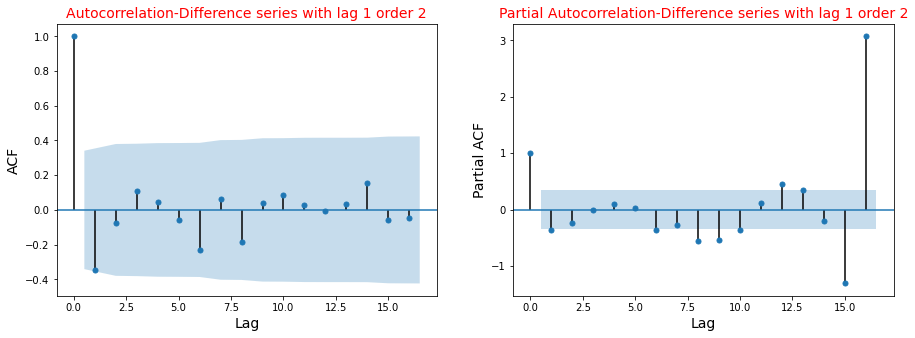

In [22]:
plt.figure(figsize=(15,5))

ax1= plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

plot_acf(lag1order2series.dropna(), ax=ax1)
ax1.set_title('Autocorrelation-Difference series with lag 1 order 2', color='red', fontsize=14)
ax1.set_xlabel('Lag', fontsize=14)
ax1.set_ylabel('ACF', fontsize=14)


plot_pacf(lag1order2series.dropna(), ax=ax2)
ax2.set_title('Partial Autocorrelation-Difference series with lag 1 order 2', color='red', fontsize=14)
ax2.set_xlabel('Lag', fontsize=14)
ax2.set_ylabel('Partial ACF', fontsize=14)

plt.show()

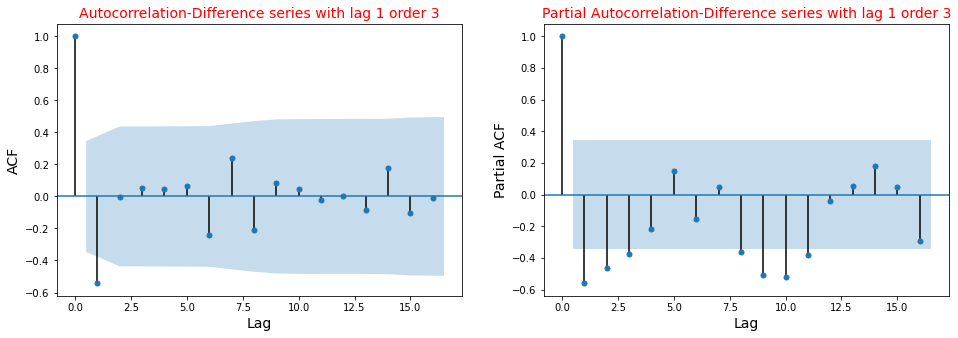

In [23]:
plt.figure(figsize=(16,5))

ax1= plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

plot_acf(lag1order3series.dropna(), ax=ax1)
ax1.set_title('Autocorrelation-Difference series with lag 1 order 3', color='red', fontsize=14)
ax1.set_xlabel('Lag', fontsize=14)
ax1.set_ylabel('ACF', fontsize=14)

plot_pacf(lag1order3series.dropna(), ax=ax2)
ax2.set_title('Partial Autocorrelation-Difference series with lag 1 order 3', color='red', fontsize=14)
ax2.set_xlabel('Lag', fontsize=14)
ax2.set_ylabel('Partial ACF', fontsize=14)

plt.show()

---------------------------------

# 2. Modeling

## 2.1. Univariant time series forecasting

In [24]:
ts_usage.index

DatetimeIndex(['2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
               '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
               '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
               '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
               '2020-04-01', '2020-05-01', '2020-06-01'],
              dtype='datetime64[ns]', name='month_start', freq=None)

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Create an empty dataframe to store evaluation metrics
columns_name= ['Model', 'RMSE','MAE','MAPE','R2']
result= pd.DataFrame(columns= columns_name)
#set i as the number of row in result dataframe
i=-1


def mean_absolute_percentage_error(y_true, y_pred):
    '''calculae MAPE'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def metrics(y_actual, y_pred):
    '''calculate evaluation metrics'''
    rmse = round(np.sqrt(mean_squared_error(y_actual, y_pred)),6)
    mae = round(mean_absolute_error(y_actual, y_pred),6)
    mape = round(mean_absolute_percentage_error(y_actual, y_pred),6)
    r2 = round(np.corrcoef(y_actual, y_pred)[0,1],6)
    metr = pd.Series((rmse,mae,mape,r2), index= ['RMSE','MAE','MAPE','R2'])
    return metr



#### Split data into train and test set

In [26]:
#set train and test size (70/30)
n = len(ts_usage)
n1 =  int(0.70 * n)


ts_train = ts_usage[:n1]
ts_test = ts_usage[n1:]

### Simple Exponential Smoothing Model (SES)
Model forecast only the next time step (one month head) as an exponentially weighted linear function of observations at prior time steps. This model supports the non-stationary time.


In [27]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
i +=1
n= len(ts_usage)
y_pred= []

for t in list(range(n-n1)):         #n1 is length of train set
    temp_train = ts_usage[:n1+t]
    #define the frequency of time series index
    temp_train = temp_train.resample('M').last()   
    SES = SimpleExpSmoothing(temp_train)
    SES_fitted = SES.fit()
    #predict only next month
    y_pred.append(SES_fitted.predict(start=len(temp_train), end=len(temp_train))) 
    
y_pred = pd.concat(y_pred) 
result = result.append(metrics(ts_usage[n1:], y_pred), ignore_index= True)
result.loc[i,'Model']='SimpleExpSmoothing' 

C:\Users\bahra\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [28]:
result

,Model,RMSE,MAE,MAPE,R2
0,SimpleExpSmoothing,0.409886,0.32936,11.462578,0.738515


### Holt Winter’s Exponential Smoothing (HWES)

Triple Exponential Smoothing (HWES) supports both seasonality and trend. 
    * Nature of the trend can be set as additive, multiplicative, or none,
    * Nature of the seasonality  can be set additive, multiplicative, or none
    * dampening of the trend or not

Model has hyperparameters that control the nature of the exponential performed for the series, trend, and seasonality, specifically:

    * smoothing_level (alpha): the smoothing coefficient for the level.

    * smoothing_slope (beta): the smoothing coefficient for the trend.

    * smoothing_seasonal (gamma): the smoothing coefficient for the seasonal component.

    * damping_slope (phi): the coefficient for the damped trend.

In [29]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
i +=1
n= len(ts_usage)
y_pred= []

for t in list(range(n-n1)):            #n1 is length of train set
    temp_train = ts_usage[:n1+t]
    #define the frequency of time series index
    temp_train = temp_train.resample('M').last()   
    ES = ExponentialSmoothing(temp_train, trend='add',damped = True, seasonal= 'mul',seasonal_periods=12)
    ES_fitted = SES.fit()
    #predict only next month
    y_pred.append(ES_fitted.predict(start=len(temp_train), end=len(temp_train))) 
    
y_pred = pd.concat(y_pred) 
result = result.append(metrics(ts_usage[n1:], y_pred), ignore_index= True)
result.loc[i,'Model']='ExponentialSmoothing'

C:\Users\bahra\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [30]:
result

,Model,RMSE,MAE,MAPE,R2
0,SimpleExpSmoothing,0.409886,0.32936,11.462578,0.738515
1,ExponentialSmoothing,0.409886,0.32936,11.462578,0.738515


### Autoregressive Model (AR) 
The method models the next step in the sequence as a linear function of the observations at prior time steps.


**Parameter of the model:**

Number of AR terms(p) is the number of lags of dependent variable(past values). For instance if p is 3, the predictors for x(3) are 
x(1) and x(2).

The trend to include in the model:

    ‘n’ - No trend.

    ‘c’ - Constant only.

    ‘t’ - Time trend only.

    ‘ct’ - Constant and time trend.

In [31]:
from statsmodels.tsa.ar_model import AutoReg
i +=1
n= len(ts_usage)
y_pred= []

for t in list(range(n-n1)):    #n1 is length of train set
    temp_train = ts_usage[:n1+t]
    #define the frequency of time series index
    temp_train = temp_train.resample('M').last()   
    AR = AutoReg(temp_train, lags=1, trend='t', seasonal= True, period=12)
    AR_fitted = AR.fit()
    #predict only next month
    y_pred.append(AR_fitted.predict(start=len(temp_train), end=len(temp_train))) 
    
y_pred = pd.concat(y_pred) 
result = result.append(metrics(ts_usage[n1:], y_pred), ignore_index= True)
result.loc[i,'Model']='Autoregressive'

In [32]:
result

,Model,RMSE,MAE,MAPE,R2
0,SimpleExpSmoothing,0.409886,0.329360,11.462578,0.738515
1,ExponentialSmoothing,0.409886,0.329360,11.462578,0.738515
2,Autoregressive,0.313047,0.266939,9.541546,0.830775


### Moving Average Model (ARMA(0,q))

The Moving Average model forecasts the next step in the sequence as the average of a window of observations at prior time steps. 

**Parameters of the model:**

Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

In [33]:
from statsmodels.tsa.arima_model import ARMA
i +=1
n= len(ts_usage)
y_pred= []

for t in list(range(n-n1)):    #n1 is length of train set
    temp_train = ts_usage[:n1+t]
    #define the frequency of time series index
    temp_train = temp_train.resample('M').last()   
    MA = ARMA(temp_train, order=(0,2))
    MA_fitted = AR.fit()
    #predict only next month
    y_pred.append(MA_fitted.predict(start=len(temp_train), end=len(temp_train))) 
    
y_pred = pd.concat(y_pred) 
result = result.append(metrics(ts_usage[n1:], y_pred), ignore_index= True)
result.loc[i,'Model']='ARMA(0,2)'

In [34]:
result

,Model,RMSE,MAE,MAPE,R2
0,SimpleExpSmoothing,0.409886,0.329360,11.462578,0.738515
1,ExponentialSmoothing,0.409886,0.329360,11.462578,0.738515
2,Autoregressive,0.313047,0.266939,9.541546,0.830775
3,"ARMA(0,2)",0.178451,0.139238,5.016632,0.950049


### Autoregressive Moving Average ARMA(p,q) Model

Model forecasts next step in the sequence by joinning AR and MA. 


**Parameter of the model:**
The (p,q) order of the model for the number of AR parameters, and MA parameters to use.

In [35]:
from statsmodels.tsa.arima_model import ARMA
i +=1
n= len(ts_usage)
y_pred= []

for t in list(range(n-n1)):    #n1 is length of train set
    temp_train = ts_usage[:n1+t]
    #define the frequency of time series index
    temp_train = temp_train.resample('M').last()   
    MA = ARMA(temp_train, order=(1,2))
    MA_fitted = AR.fit()
    #predict only next month
    y_pred.append(MA_fitted.predict(start=len(temp_train), end=len(temp_train))) 
    
y_pred = pd.concat(y_pred) 
result = result.append(metrics(ts_usage[n1:], y_pred), ignore_index= True)
result.loc[i,'Model']='ARMA(1,2)'

In [36]:
result

,Model,RMSE,MAE,MAPE,R2
0,SimpleExpSmoothing,0.409886,0.329360,11.462578,0.738515
1,ExponentialSmoothing,0.409886,0.329360,11.462578,0.738515
2,Autoregressive,0.313047,0.266939,9.541546,0.830775
3,"ARMA(0,2)",0.178451,0.139238,5.016632,0.950049
4,"ARMA(1,2)",0.178451,0.139238,5.016632,0.950049


### Autoregressive Integrated Moving Average (ARIMA)
ARIMA doesn't support seasonal time series. It supports them when seasonality component using methods such as seasonal differencing, is removed.

**Non-seasonal parameters of model are labeled p,d,and q:**

    * Number of AR (Auto-Regressive) terms (p) is number of lags of dependent variable (past values). 
    
    * Number of Differences (d) is associated with the integrated part of the model, which effects the amount of 
    differencing to apply to a time series. Non stationarity series which has trend and seasonality requires positive 
    level of differencing (d>0). 
    
    * Number of MA (Moving Average) terms (q)is size of the moving average part window of the model .




After stationrizing the time series of daily usage, p and q are selected based on ACF and PACF respectively.




In [37]:
from statsmodels.tsa.arima_model import ARIMA
i +=1
differenced= difference(ts_usage, 12)
n= len(differenced)
n1 = int(0.70* n)

y_pred= []

for t in list(range(n-n1)):    #n1 is length of train set
    temp_train = differenced[:n1+t]
    temp_test = differenced[n1+t:]
    #define the frequency of time series index
    #temp_train = temp_train.resample('M').last()   
    arima = ARIMA(temp_train, order=(7,0,1))
    arima_fitted = arima.fit(start_params=(0,2), transparams= False, method='mle', trend='nc')
    #predict only next month
    forecast= arima_fitted.predict(start=len(temp_train) , end=len(temp_train)+ len(temp_test), dynamic=False).conf_int()
    # invert the differenced forecast to something usable
    forecast = forecast + differenced[len(temp_train)]
    y_pred.append(forecast) 

#y_pred = pd.concat(y_pred) 
result = result.append(metrics(lag1order2series[n1:].values, y_pred), ignore_index= True)
result.loc[i,'Model']='ARIMA'

ValueError: could not broadcast input array from shape (0,1) into shape (1,1)

### Seasonal Autoregressive Integrated Moving Average (SARIMAX)
SARIMA supports seasonal time series. 

**Non-seasonal parameters of model (p,d,q):**

    * Number of AR (Auto-Regressive) terms (p) is number of lags of dependent variable (past values). 
    
    * Number of Differences (d) is associated with the integrated part of the model, which effects the amount of 
    differencing to apply to a time series. Non stationarity series which has trend and seasonality requires positive 
    level of differencing (d>0). 
    
    * Number of MA (Moving Average) terms (q)is size of the moving average part window of the model.
    

**seasonal parameters of model (P,D,Q)**:
these parameters are applied to seasonal component


**m: The number of time steps for a single seasonal period**



Summary of model has an attribute of BIC. **Bayesian Information Criterion:**

The information criteria adjust the goodness-of-fit of a model by imposing a penalty based on the number of parameters used.
The way to use the information criteria is to fit several models, each with a different number of parameters, and choose the one with the lowest Bayesian Information Criterion. It deals with the trade-off between the goodness of fit of the model and the complexity of the model itself.

In [ ]:
#set train and test size (70/30)
n = len(ts_usage)
n1 =  int(0.70 * n)


ts_train = ts_usage[:n1]
ts_test = ts_usage[n1:]

In [38]:
print('range of train data:' , ts_train.index[0],'   ' ,ts_train.index[-1])
print('range of test data: ' , ts_test.index[0],'   ' ,ts_test.index[-1])

range of train data: 2017-08-01 00:00:00     2019-07-01 00:00:00
range of test data:  2019-08-01 00:00:00     2020-06-01 00:00:00


In [39]:
import itertools
# Specify the parameter search space
p = range(0, 2)   #AR,number of past values as predictors
d = range(0, 3)   #Order of difference to deal with seasonality
q = range(0, 3)   #MA, number of errors related to difference between actual and MA prediction for past values


#Generate different combinations of non seasonal parameters: p, d,q
pdq = list(itertools.product(p, d, q))

#Generate different combinations of seasonal parameters P,D,Q 
#Time series has yearly seasonality (m=12)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

trend = ['n','c','t','ct']

#### SARIMAX with constant trend

In [40]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

from statsmodels.tsa.statespace.sarimax import SARIMAX


AIC_c_trend = []
SARIMAX_c_trend = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_train,
                                            trend= 'c',
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            fitted_model = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, fitted_model.aic), end='\r')
            AIC_c_trend.append(fitted_model.aic)
            SARIMAX_c_trend .append([param, param_seasonal])
        except:
            continue

In [41]:
print('SARIMAX Model{}x{} with Constant Trend:'\
     .format(SARIMAX_c_trend[AIC_c_trend.index(min(AIC_c_trend))][0]\
             , SARIMAX_c_trend[AIC_c_trend.index(min(AIC_c_trend))][1]))


print('\nThe smallest AIC is {}'.format(min(AIC_c_trend)))


SARIMAX Model(1, 0, 0)x(1, 0, 0, 12) with Constant Trend:

The smallest AIC is -9.99222815584153


#### SARIMAX with time dependent trend

In [42]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

from statsmodels.tsa.statespace.sarimax import SARIMAX


AIC_t_trend = []
SARIMAX_t_trend = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_train,
                                            trend= 't',
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            fitted_mod = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, fitted_mod.aic), end='\r')
            AIC_t_trend.append(fitted_mod.aic)
            SARIMAX_t_trend.append([param, param_seasonal])
        except:
            continue

In [43]:
print('SARIMAX Model{}x{} with Time Dependent Trend:'\
     .format(SARIMAX_t_trend[AIC_t_trend.index(min(AIC_t_trend))][0]\
             , SARIMAX_t_trend[AIC_t_trend.index(min(AIC_t_trend))][1]))


print('\nThe smallest AIC is {}'.format(min(AIC_t_trend)))

SARIMAX Model(1, 1, 2)x(1, 0, 0, 12) with Time Dependent Trend:

The smallest AIC is -5.628948359636592


#### SARIMAX with constant and time dependent trend

In [44]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

from statsmodels.tsa.statespace.sarimax import SARIMAX


AIC_ct_trend = []
SARIMAX_ct_trend = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_train,
                                            trend= 'ct',
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            fitted_mod = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, fitted_mod.aic), end='\r')
            AIC_ct_trend.append(fitted_mod.aic)
            SARIMAX_ct_trend.append([param, param_seasonal])
        except:
            continue

In [45]:
print('SARIMAX Model{}x{} with Constant and Time Dependent Trend:'\
     .format(SARIMAX_ct_trend[AIC_ct_trend.index(min(AIC_ct_trend))][0]\
             , SARIMAX_ct_trend[AIC_ct_trend.index(min(AIC_ct_trend))][1]))


print('\nThe smallest AIC is {}'.format(min(AIC_ct_trend)))

SARIMAX Model(1, 0, 0)x(1, 0, 0, 12) with Constant and Time Dependent Trend:

The smallest AIC is -8.67663097021736


#### SARIMAX with no trend

In [46]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

from statsmodels.tsa.statespace.sarimax import SARIMAX


AIC_n_trend = []
SARIMAX_n_trend = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_train,
                                            trend= 'n',
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            fitted_mod = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, fitted_mod.aic), end='\r')
            AIC_n_trend.append(fitted_mod.aic)
            SARIMAX_n_trend.append([param, param_seasonal])
        except:
            continue

In [47]:
print('SARIMAX Model{}x{} without Trend:'\
     .format(SARIMAX_n_trend[AIC_n_trend.index(min(AIC_n_trend))][0]\
             , SARIMAX_n_trend[AIC_n_trend.index(min(AIC_n_trend))][1]))


print('\nThe smallest AIC is {}'.format(min(AIC_n_trend)))

SARIMAX Model(1, 1, 2)x(1, 0, 0, 12) without Trend:

The smallest AIC is -7.571470481038599


In [48]:
sarimax_params = pd.DataFrame([
    pd.Series(('n', SARIMAX_n_trend[AIC_n_trend.index(min(AIC_n_trend))][0], SARIMAX_n_trend[AIC_n_trend.index(min(AIC_n_trend))][1],min(AIC_n_trend))
          ,index= ['trend','param','seasonal_param','AIC']),
    pd.Series(('t', SARIMAX_t_trend[AIC_t_trend.index(min(AIC_t_trend))][0], SARIMAX_t_trend[AIC_t_trend.index(min(AIC_t_trend))][1],min(AIC_t_trend))
          ,index= ['trend','param','seasonal_param','AIC']),
    pd.Series(('c', SARIMAX_c_trend[AIC_c_trend.index(min(AIC_c_trend))][0], SARIMAX_c_trend[AIC_c_trend.index(min(AIC_c_trend))][1],
                        min(AIC_c_trend)) ,index= ['trend','param','seasonal_param', 'AIC']),
    pd.Series(('ct', SARIMAX_ct_trend[AIC_ct_trend.index(min(AIC_ct_trend))][0], SARIMAX_ct_trend[AIC_ct_trend.index(min(AIC_ct_trend))][1],min(AIC_ct_trend))
          ,index= ['trend','param','seasonal_param','AIC'])
])

print('Params Grid for SARIMAX')
sarimax_params

Params Grid for SARIMAX


,trend,param,seasonal_param,AIC
0,n,"(1, 1, 2)","(1, 0, 0, 12)",-7.571470
1,t,"(1, 1, 2)","(1, 0, 0, 12)",-5.628948
2,c,"(1, 0, 0)","(1, 0, 0, 12)",-9.992228
3,ct,"(1, 0, 0)","(1, 0, 0, 12)",-8.676631


### Fit  SARIMAX Model with selected params

In [59]:
# Let's fit this model
sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                trend= 'c',
                                order= sarimax_params.loc[sarimax_params.trend == 'c', 'param'].item(),
                                seasonal_order= sarimax_params.loc[sarimax_params.trend == 'c', 'seasonal_param'].item(),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

sarimax_fitted = sarimax.fit()
sarimax_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:            avg_daily_usage_per_dwl   No. Observations:                   24
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                   8.996
Date:                            Mon, 15 Mar 2021   AIC                             -9.992
Time:                                    23:36:14   BIC                             -8.401
Sample:                                08-01-2017   HQIC                           -10.995
                                     - 07-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.8605      0.986     -1.887      0.059      -3.792       0.071
ar.L1         -0.3593      0.608     -0.591      0.555      -1.552       0.833
ar.S.L12       1.3069      0.084     15.528      0.000       1.142       1.472
sigma2         0.0114      0.007      1.547      0.122      -0.003       0.026
===================================================================================
Ljung-Box (Q):                        9.13   Jarque-Bera (JB):                 0.60
Prob(Q):                              0.52   Prob(JB):                         0.74
Heteroskedasticity (H):               3.48   Skew:                            -0.55
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

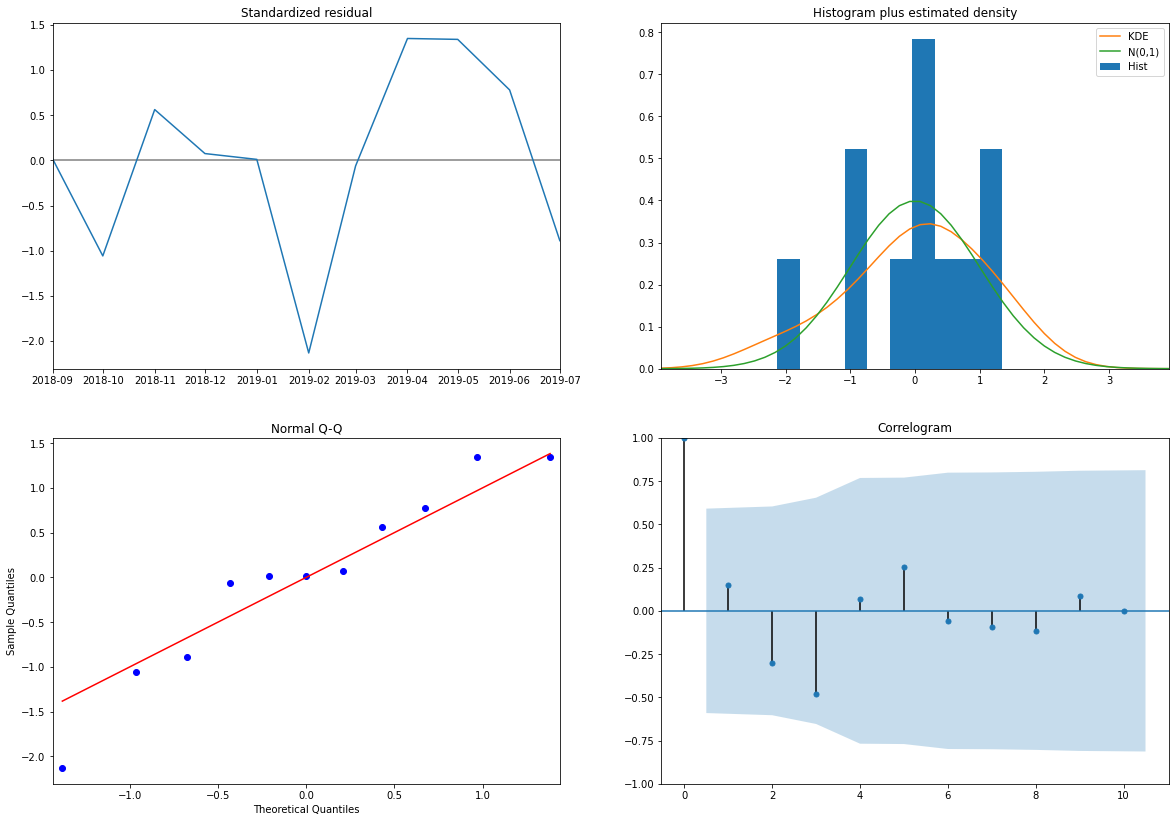

In [60]:

sarimax_fitted.plot_diagnostics(figsize=(20, 14))
plt.show()

In [74]:
#set train and test size (70/30)
n = len(ts_usage)
n1 =  int(0.70 * n)


ts_train = ts_usage[:n1]
ts_test = ts_usage[n1:]

In [75]:
y_pred_train = sarimax_fitted.predict(start= 0, end= n)
y_pred = sarimax_fitted.predict(start= 0, end= n)


actual_pred = pd.concat([ts_usage , y_pred], axis=1)
actual_pred.columns= ['Avg Daily Usage per Dwelling','SARIMAX Prediction']
actual_pred 

,Avg Daily Usage per Dwelling,SARIMAX Prediction
2017-08-01,4.449854,0.000000
2017-09-01,3.919119,-3.459375
2017-10-01,3.766953,-3.268672
2017-11-01,3.344390,-3.213996
2017-12-01,3.117547,-3.062161
2018-01-01,2.834768,-2.980652
2018-02-01,2.963034,-2.879045
2018-03-01,2.852509,-2.925133
2018-04-01,3.286363,-2.885419
2018-05-01,3.407078,-3.041311


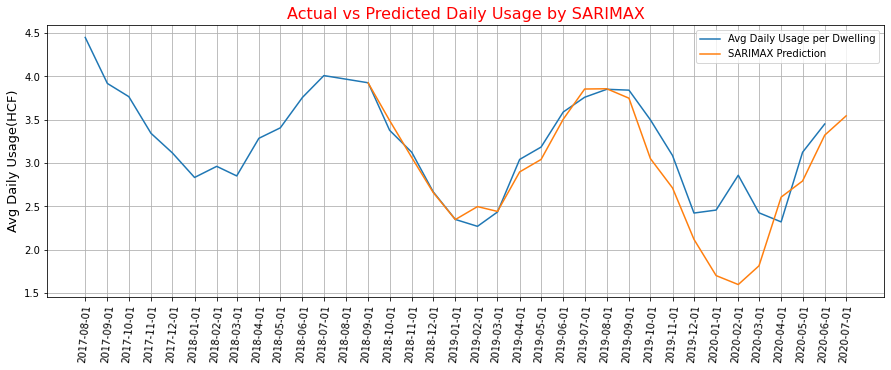

In [79]:
plt.figure(figsize=(15,5))
plt.plot(actual_pred['Avg Daily Usage per Dwelling'], label='Avg Daily Usage per Dwelling')
plt.plot(actual_pred.loc['2018-09-1':,'SARIMAX Prediction'], label='SARIMAX Prediction')
plt.xticks(actual_pred.index , rotation=85)
plt.title('Actual vs Predicted Daily Usage by SARIMAX', color='red', fontsize=16)
plt.ylabel('Avg Daily Usage(HCF)', fontsize=13)

plt.grid(which= 'both')
plt.legend()
plt.show()

In [82]:
ts_test

month_start
2019-08-01    3.851925
2019-09-01    3.841939
2019-10-01    3.499741
2019-11-01    3.087451
2019-12-01    2.424253
2020-01-01    2.458569
2020-02-01    2.860309
2020-03-01    2.426935
2020-04-01    2.322215
2020-05-01    3.125174
2020-06-01    3.451580
Name: avg_daily_usage_per_dwl, dtype: float64

In [84]:
actual_pred.loc['2019-08-01':'2020-06-01','SARIMAX Prediction']

2019-08-01    3.858044
2019-09-01    3.749098
2019-10-01    3.052586
2019-11-01    2.713817
2019-12-01    2.120803
2020-01-01    1.702670
2020-02-01    1.599392
2020-03-01    1.815419
2020-04-01    2.607866
2020-05-01    2.794192
2020-06-01    3.322585
Freq: MS, Name: SARIMAX Prediction, dtype: float64

In [85]:
#Confidence interval for predicted values
conf_int = sarimax_fitted.get_prediction(start=0, end= n).conf_int()
conf_int

,lower avg_daily_usage_per_dwl,upper avg_daily_usage_per_dwl
2017-08-01,-1959.963985,1959.963985
2017-09-01,-1963.423370,1956.504621
2017-10-01,-1963.232668,1956.695324
2017-11-01,-1963.177991,1956.750000
2017-12-01,-1963.026157,1956.901834
2018-01-01,-1962.944648,1956.983343
2018-02-01,-1962.843041,1957.084951
2018-03-01,-1962.889129,1957.038862
2018-04-01,-1962.849415,1957.078576
2018-05-01,-1963.005307,1956.922685


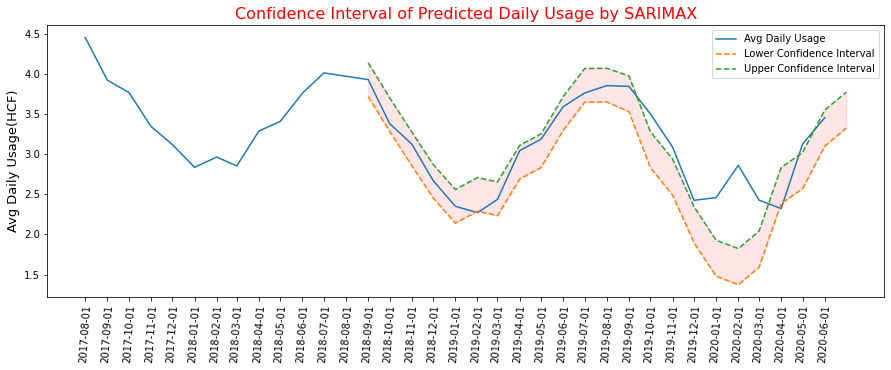

In [87]:
#Extract lower and upper confidence interval for predicted values
conf_int = sarimax_fitted.get_prediction(start=4, end= n).conf_int()
lower_CI = conf_int.loc['2018-09-01':,'lower avg_daily_usage_per_dwl']
upper_CI = conf_int.loc['2018-09-01': ,'upper avg_daily_usage_per_dwl']


plt.figure(figsize=(15,5))

# Plot actual value and confidence interval prediction
plt.plot(ts_usage.index, ts_usage, label='Avg Daily Usage')
plt.plot(lower_CI.index, lower_CI, linestyle='--', label='Lower Confidence Interval')
plt.plot(upper_CI.index, upper_CI, linestyle='--', label='Upper Confidence Interval')
#Fille the confidence interval
plt.fill_between(lower_CI.index, lower_CI, upper_CI, color='r', alpha=0.1)


plt.title('Confidence Interval of Predicted Daily Usage by SARIMAX', c='red', fontsize=16)
plt.xticks(ts_usage.index, rotation= 86)
plt.ylabel('Avg Daily Usage(HCF)', fontsize=13)
plt.legend(loc='best')
plt.show()

In [88]:
i += 1

result = result.append(metrics(ts_usage['2019-08-01':], 
                               actual_pred.loc['2019-08-01':'2020-06-01','SARIMAX Prediction']), ignore_index= True)
result.loc[i,'Model']='SARIMA (1, 0, 0)x(1, 0, 0, 12)'

## Performance of Univariant Time Forecasting Models

In [95]:
result

,Model,RMSE,MAE,MAPE,R2
0,SimpleExpSmoothing,0.409886,0.329360,11.462578,0.738515
1,ExponentialSmoothing,0.409886,0.329360,11.462578,0.738515
2,Autoregressive,0.313047,0.266939,9.541546,0.830775
3,"ARMA(0,2)",0.178451,0.139238,5.016632,0.950049
4,"ARMA(1,2)",0.178451,0.139238,5.016632,0.950049
5,"SARIMA (1, 0, 0)x(1, 0, 0, 12)",0.537952,0.417924,15.147803,0.862873


## 2.2 Linear Models

In [96]:
data['RATE'] = data['RATE'].astype('category')

In [97]:
df = data[['RATE', 'year', 'month','avg_daily_usage_per_dwl']]
print(df.shape)
df.head()

(210, 4)


,RATE,year,month,avg_daily_usage_per_dwl
11,COM,2017,8,1.397697
12,COM,2017,9,1.252005
13,COM,2017,10,1.196575
14,COM,2017,11,1.151210
15,COM,2017,12,1.087427


### Encoding RATE

In [98]:
#Encode categorical features
from sklearn.preprocessing import LabelEncoder


def label_encod(df_column):
    df_column = LabelEncoder().fit_transform(df_column)
    return df_column


df['RATE']= label_encod(df.RATE)

### Encoding year and month

In [99]:
encoded_cols = pd.get_dummies(df['year'], drop_first= False, prefix= 'Y')
df = df.join(encoded_cols).drop('year', axis=1)

encoded_cols = pd.get_dummies(df['month'], drop_first= True, prefix= 'M')
df = df.join(encoded_cols).drop('month', axis=1)

### Split data into train and test set

In [100]:
#set train and test size (70/30)
n = df.shape[0]
n1 =  int(0.70 * n)


y_train = df.loc[:n1,'avg_daily_usage_per_dwl']
y_test = df.loc[n1:,'avg_daily_usage_per_dwl']

X = df.drop('avg_daily_usage_per_dwl', axis=1)
X_train = X.loc[:n1,:]
X_test = X.loc[n1:,:]

print(X_train.shape , y_train.shape)

(114, 16) (114,)


### Linear Bayesian Regression (Priors)

In [104]:
from sklearn.linear_model import BayesianRidge
bay_reg = BayesianRidge()
bay_reg.fit(X_train, y_train)
y_pred = bay_reg.predict(X_test)


result = result.append(metrics(y_test, y_pred), ignore_index= True)

result.loc[i,'Model']='BayesianRidge'

In [105]:
result

,Model,RMSE,MAE,MAPE,R2
0,SimpleExpSmoothing,0.409886,0.329360,11.462578,0.738515
1,ExponentialSmoothing,0.409886,0.329360,11.462578,0.738515
2,Autoregressive,0.313047,0.266939,9.541546,0.830775
3,"ARMA(0,2)",0.178451,0.139238,5.016632,0.950049
4,"ARMA(1,2)",0.178451,0.139238,5.016632,0.950049
5,"SARIMA (1, 0, 0)x(1, 0, 0, 12)",0.537952,0.417924,15.147803,0.862873
6,NaN,0.274558,0.225684,200.045553,-0.273716
7,BayesianRidge,NaN,NaN,NaN,NaN
8,BayesianRidge,0.274558,0.225684,200.045553,-0.273716


In [106]:
i

8

### Lasso Regression Model
Lasso for feature selection 

In [107]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# Specify a uniform random distribution as the hyperparameter search space
param_dist = {'alpha':np.logspace(-4, 0, 50)}

# Create the RandomizedSearchCV object
estimator = Lasso()
rand_search = RandomizedSearchCV(estimator, param_distributions= param_dist, n_iter= 50, n_jobs=-1)

# Fit to the training set
rand_search.fit(X_train,y_train)

# Predict on the test set and compute metrics
y_pred = rand_search.best_estimator_.predict(X_test)


i += 1
result = result.append(metrics(y_test, y_pred), ignore_index= True)

result.loc[i,'Model']='Lasso'

In [108]:
result

,Model,RMSE,MAE,MAPE,R2
0,SimpleExpSmoothing,0.409886,0.329360,11.462578,0.738515
1,ExponentialSmoothing,0.409886,0.329360,11.462578,0.738515
2,Autoregressive,0.313047,0.266939,9.541546,0.830775
3,"ARMA(0,2)",0.178451,0.139238,5.016632,0.950049
4,"ARMA(1,2)",0.178451,0.139238,5.016632,0.950049
5,"SARIMA (1, 0, 0)x(1, 0, 0, 12)",0.537952,0.417924,15.147803,0.862873
6,NaN,0.274558,0.225684,200.045553,-0.273716
7,BayesianRidge,NaN,NaN,NaN,NaN
8,BayesianRidge,0.274558,0.225684,200.045553,-0.273716
9,Lasso,0.262176,0.214882,196.283369,-0.434866


### Elastic Net Regression Model

In [109]:
# Import Elastic Net
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV



# Specify the hyperparameter search space
param_dist = {'alpha':np.logspace(-4, 0, 50)}

# Create the RandomizedSearchCV object
estimator = ElasticNet()
rand_search = RandomizedSearchCV(estimator, param_distributions= param_dist, n_iter=200, n_jobs=-1)

# Fit to the training set
rand_search.fit(X_train,y_train)


# Predict on the test set and compute metrics
y_pred = rand_search.best_estimator_.predict(X_test)

i += 1
result = result.append(metrics(y_test, y_pred), ignore_index= True)

result.loc[i,'Model']='ElasticNet'

In [110]:
result

,Model,RMSE,MAE,MAPE,R2
0,SimpleExpSmoothing,0.409886,0.329360,11.462578,0.738515
1,ExponentialSmoothing,0.409886,0.329360,11.462578,0.738515
2,Autoregressive,0.313047,0.266939,9.541546,0.830775
3,"ARMA(0,2)",0.178451,0.139238,5.016632,0.950049
4,"ARMA(1,2)",0.178451,0.139238,5.016632,0.950049
5,"SARIMA (1, 0, 0)x(1, 0, 0, 12)",0.537952,0.417924,15.147803,0.862873
6,NaN,0.274558,0.225684,200.045553,-0.273716
7,BayesianRidge,NaN,NaN,NaN,NaN
8,BayesianRidge,0.274558,0.225684,200.045553,-0.273716
9,Lasso,0.262176,0.214882,196.283369,-0.434866


#### Linear regressor don't consider trend and seasonality which causes their poor performance.

## 2.3 Tree Based Models

### RndomizedSearchCV RandomForest Regressor

#### Building and Tunnig RandomForeset Regressor

In [111]:
import random 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


#Instantiat RandomForest Regression model
estimator = RandomForestRegressor()

#Create the RandomizedSearchCV object

params_dis= {'n_estimators': list(range(100, 300, 25)),
             'max_depth': list(range(3,15)),
             'criterion': ['mse', 'mae']
            }



rf_rand_search = RandomizedSearchCV(estimator, param_distributions = params_dis, \
                                    refit= True, n_iter = 10, n_jobs=-1, cv= 5)


#Fit the RandomizedSearchCV object to the train set
rf_rand_search.fit(X_train, y_train)

#Predict on test set using best estimator 
rf_rand_search.best_params_

{'n_estimators': 275, 'max_depth': 9, 'criterion': 'mse'}

#### Prediction

In [114]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Predict on test set using best estimator 
y_pred = rf_rand_search.best_estimator_.predict(X_test)


i += 1
result = result.append(metrics(y_test, y_pred), ignore_index= True)

result.loc[i,'Model']='RandomizedSearchCV RandomForest Regressor'

In [115]:
result

,Model,RMSE,MAE,MAPE,R2
0,SimpleExpSmoothing,0.409886,0.329360,11.462578,0.738515
1,ExponentialSmoothing,0.409886,0.329360,11.462578,0.738515
2,Autoregressive,0.313047,0.266939,9.541546,0.830775
3,"ARMA(0,2)",0.178451,0.139238,5.016632,0.950049
4,"ARMA(1,2)",0.178451,0.139238,5.016632,0.950049
5,"SARIMA (1, 0, 0)x(1, 0, 0, 12)",0.537952,0.417924,15.147803,0.862873
6,NaN,0.274558,0.225684,200.045553,-0.273716
7,BayesianRidge,NaN,NaN,NaN,NaN
8,BayesianRidge,0.274558,0.225684,200.045553,-0.273716
9,Lasso,0.262176,0.214882,196.283369,-0.434866


## Feature Importance

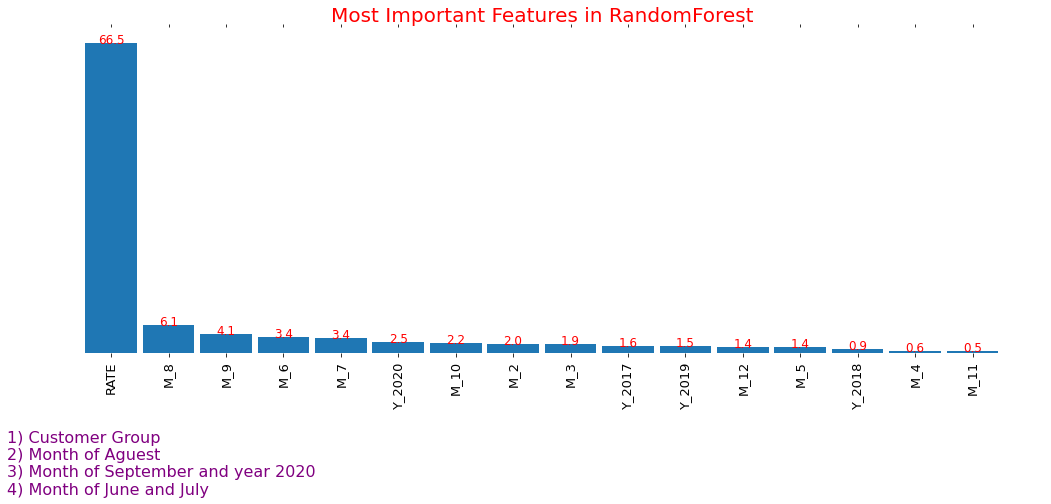

In [116]:

feature_impotances= pd.Series(rf_rand_search.best_estimator_.feature_importances_,\
                              index= X.columns).sort_values(ascending= False)


fig= plt.figure(figsize=(18,6))
bars= plt.bar(x= feature_impotances.index, 
              height= 100*feature_impotances,
             width=0.9,
             align= 'center')

plt.xticks(rotation= 90,fontsize=13)
plt.title('Most Important Features in RandomForest', fontsize= 20, color= 'red')


#direct label each bar with Y axis values
for bar in bars:
    plt.gca().text( bar.get_x() + bar.get_width()/2 , bar.get_height(),
                   '{:.1f}'.format(bar.get_height()), ha='center', color='red', fontsize=12) 

#remove all the ticks on both axes, and tick labels on the Y axis
plt.tick_params (top='off', bottom='off', left=False , right=False, labelleft= False, labelbottom='off')

#remove frame of the chart
for spine in plt.gca().spines.values():
    spine.set_visible (False)
    
txt= '''1) Customer Group\n2) Month of Aguest  \n3) Month of September and year 2020\
\n4) Month of June and July'''
fig.text(0.1,-0.2,txt, fontsize=16, color= 'purple')


plt.show()

### XGBoost Model

In [117]:
import xgboost as xgb
reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
reg.fit(X_train, y_train,
       verbose=False) # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)

i += 1
result = result.append(metrics(y_test, y_pred), ignore_index= True)

result.loc[i,'Model']='XGB Regressor'

In [118]:
result

,Model,RMSE,MAE,MAPE,R2
0,SimpleExpSmoothing,0.409886,0.329360,11.462578,0.738515
1,ExponentialSmoothing,0.409886,0.329360,11.462578,0.738515
2,Autoregressive,0.313047,0.266939,9.541546,0.830775
3,"ARMA(0,2)",0.178451,0.139238,5.016632,0.950049
4,"ARMA(1,2)",0.178451,0.139238,5.016632,0.950049
5,"SARIMA (1, 0, 0)x(1, 0, 0, 12)",0.537952,0.417924,15.147803,0.862873
6,NaN,0.274558,0.225684,200.045553,-0.273716
7,BayesianRidge,NaN,NaN,NaN,NaN
8,BayesianRidge,0.274558,0.225684,200.045553,-0.273716
9,Lasso,0.262176,0.214882,196.283369,-0.434866


### Bayesian Optimization RandomForest Regressor

In [121]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score

def rms(y_actual,y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))

my_scorer = make_scorer(rms, greater_is_better=False)

pbounds = {
    'n_estimators': (100, 10000),
    'max_depth': (3,15),
    'min_samples_leaf': (1,4),
    'min_samples_split': (2,10),
}
 
def rf_hyper_param(n_estimators,
                   max_depth,
                   min_samples_leaf,
                   min_samples_split):
 
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
 
    estimator = RandomForestRegressor(n_estimators=n_estimators, 
                                max_depth=int(max_depth),
                                min_samples_leaf=int(min_samples_leaf),
                                min_samples_split=int(min_samples_split),
                                n_jobs=1)
    
    return -np.mean(cross_val_score(estimator, X_train, y_train, cv=3))
 
optimizer = BayesianOptimization(
    f=rf_hyper_param,
    pbounds= pbounds,
    random_state=1,
)

In [122]:
optimizer.maximize(
    init_points=3,
    n_iter=20,
    acq='ei'
)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  1.062    |  8.004    |  3.161    |  2.001    |  3.093e+0 |
|  2        |  1.278    |  4.761    |  1.277    |  3.49     |  3.521e+0 |
|  3        |  0.9385   |  7.761    |  2.616    |  5.354    |  6.884e+0 |
|  4        |  1.257    |  4.298    |  3.175    |  5.441    |  3.52e+03 |
|  5        |  1.229    |  4.378    |  1.081    |  4.556    |  3.536e+0 |
|  6        |  0.9111   |  12.79    |  1.727    |  2.429    |  3.51e+03 |
|  7        |  1.182    |  5.579    |  1.319    |  3.821    |  3.529e+0 |
|  8        |  0.8463   |  7.633    |  1.471    |  7.934    |  3.544e+0 |
|  9        |  0.9219   |  8.783    |  2.511    |  2.314    |  3.522e+0 |
|  10       |  1.129    |  6.232    |  3.705    |  5.794    |  3.536e+0 |
|  11       |  1.18     |  4.839    |  1.745    |  6.001    |  3.521e+0 |
|  12       |  0.9986   |  7.02     | 

In [123]:
best_RFRegressor = RandomForestRegressor(n_estimators= 3, 
                                max_depth= 3,
                                min_samples_leaf= 1,
                                min_samples_split= 2,
                                n_jobs=1)

In [124]:
best_RFRegressor.fit(X_train, y_train)
y_pred= best_RFRegressor.predict(X_test)
i += 1
result = result.append(metrics(y_test, y_pred), ignore_index= True)

result.loc[i,'Model']='Bayesian Process-RandomForest Regressor'

In [129]:
result= result.set_index('Model')

result

,RMSE,MAE,MAPE,R2
Model,,,,
SimpleExpSmoothing,0.409886,0.329360,11.462578,0.738515
ExponentialSmoothing,0.409886,0.329360,11.462578,0.738515
Autoregressive,0.313047,0.266939,9.541546,0.830775
"ARMA(0,2)",0.178451,0.139238,5.016632,0.950049
"ARMA(1,2)",0.178451,0.139238,5.016632,0.950049
"SARIMA (1, 0, 0)x(1, 0, 0, 12)",0.537952,0.417924,15.147803,0.862873
BayesianRidge,0.274558,0.225684,200.045553,-0.273716
Lasso,0.262176,0.214882,196.283369,-0.434866
ElasticNet,0.263902,0.216201,197.374565,-0.422470
